# NSL-KDD Dataset 4-Class Classification from Article 4
## CTGAN (Conditional Tabular Generative Adversarial Network)
- Main objective is to try different sampling techniques to assist with imbalance and improve accuracy
- No significant impact using traditional methods such as SMOTE or RandomSampling
- This example attempts to use ydata-synthetic CTGAN synthetic sample generation (still experimenting with the parameters for ydata-synthetic CTGAN)

In [ ]:
# install ydata-synthetic lib
!pip install ydata-synthetic

# Tabular Synthetic Data Generation with CTGAN
This notebook is an example of how to use CTGAN to generate synthetic tabular data with numeric and categorical features.


##Imports

In [1]:
# CTGAN Imports
#from pmlb import fetch_data

from ydata_synthetic.synthesizers.regular import RegularSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

In [2]:
# Original Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import stats for ANOVA feature selection
from scipy import stats

#from google.colab import drive
#drive.mount('/content/drive') #mount

## Load the data

### Training Dataset

In [5]:
# --- Importing Train Dataset ---
# NSL-KDD, 43 features, 125973 samples, Multiclass Classification (From text file)
KDDTrain = pd.read_csv('KDDTrain+.txt', header = None) # Data with difficulty level
# Column Headings
KDDTrain.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'difficulty']

# We will not utilize the 'difficulty' feature for now
KDDTrain.drop('difficulty', axis=1, inplace=True)

### Testing Dataset

In [6]:
# --- Importing Test Dataset ---
# NSL-KDD, 43 features, 22544 samples, Multiclass Classification (From text file)
KDDTest = pd.read_csv('KDDTest+.txt', header = None) # Data with difficulty level
# Column Headings
KDDTest.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class', 'difficulty']

# We will not utilize the 'difficulty' feature for now
KDDTest.drop('difficulty', axis=1, inplace=True)

## Data Handling

###Data Cleaning

In [7]:
# We drop 'num_outbound_cmds' from both training and testing dataset because every instance is equal to 0 in both datasets
KDDTrain.drop("num_outbound_cmds",axis=1,inplace=True)
KDDTest.drop("num_outbound_cmds",axis=1,inplace=True)

# We replace all instances with a value of 2 to 1 (1 instead of 0 because of Dr. Mishra's request) because the feature should be a binary value (0 or 1)
KDDTrain['su_attempted'] = KDDTrain['su_attempted'].replace(2, 1)
KDDTest['su_attempted'] = KDDTest['su_attempted'].replace(2, 1)

In [6]:
# Used for ensuring dataset integrity and if the data has successfully been cleaned
for i in KDDTrain.columns:
  print('unique values in "{}":\n'.format(i),KDDTrain[i].sort_values(ascending=True).unique()) # Display the unique values in ascending order

unique values in "duration":
 [    0     1     2 ... 42862 42888 42908]
unique values in "protocol_type":
 ['icmp' 'tcp' 'udp']
unique values in "service":
 ['IRC' 'X11' 'Z39_50' 'aol' 'auth' 'bgp' 'courier' 'csnet_ns' 'ctf'
 'daytime' 'discard' 'domain' 'domain_u' 'echo' 'eco_i' 'ecr_i' 'efs'
 'exec' 'finger' 'ftp' 'ftp_data' 'gopher' 'harvest' 'hostnames' 'http'
 'http_2784' 'http_443' 'http_8001' 'imap4' 'iso_tsap' 'klogin' 'kshell'
 'ldap' 'link' 'login' 'mtp' 'name' 'netbios_dgm' 'netbios_ns'
 'netbios_ssn' 'netstat' 'nnsp' 'nntp' 'ntp_u' 'other' 'pm_dump' 'pop_2'
 'pop_3' 'printer' 'private' 'red_i' 'remote_job' 'rje' 'shell' 'smtp'
 'sql_net' 'ssh' 'sunrpc' 'supdup' 'systat' 'telnet' 'tftp_u' 'tim_i'
 'time' 'urh_i' 'urp_i' 'uucp' 'uucp_path' 'vmnet' 'whois']
unique values in "flag":
 ['OTH' 'REJ' 'RSTO' 'RSTOS0' 'RSTR' 'S0' 'S1' 'S2' 'S3' 'SF' 'SH']
unique values in "src_bytes":
 [         0          1          4 ...  693375640 1167519497 1379963888]
unique values in "dst_bytes

In [7]:
for i in KDDTest.columns:
  print('unique values in "{}":\n'.format(i),KDDTest[i].sort_values(ascending=True).unique()) # Display the unique values in ascending order

unique values in "duration":
 [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    18    19    20    21    22    23    24
    25    26    27    28    29    30    31    32    33    35    37    39
    40    41    43    44    48    49    50    54    57    58    59    60
    61    62    63    65    67    69    71    72    73    75    79    84
    89    90    91    92    94    96    99   107   111   112   116   117
   118   126   133   134   135   136   138   140   141   142   148   154
   160   163   171   182   184   192   198   199   205   207   208   214
   218   226   239   242   247   253   277   280   281   282   283   284
   285   287   288   289   293   297   300   314   315   317   345   373
   426   433   440   469   657   684   703   707   718   731   748   774
   781   786   788   789   791   792   794   795   796   798   799   801
   802   803   804   805   806   807   808   809   810   811   812   813
   814   815   816   

### Class Assignment

In [8]:
# Distribution of attack classes in training dataset
KDDTrain['class'].value_counts()

class
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [9]:
# Distribution of attack classes in testing dataset
KDDTest['class'].value_counts()

class
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: count, dtype: int64

In [8]:
# Change training attack labels to their respective attack class for multiclass classification
KDDTrain['class'].replace(['neptune', 'smurf', 'back', 'teardrop', 'pod', 'land'],'DoS',inplace=True) # 6 sub classes of DoS
KDDTrain['class'].replace(['satan', 'ipsweep', 'portsweep', 'nmap'],'Probe',inplace=True) # 4 sub classes of Probe
KDDTrain['class'].replace(['warezclient', 'guess_passwd', 'warezmaster', 'imap', 'ftp_write', 'multihop', 'phf','spy'],'R2L',inplace=True) # 8 sub classes of R2L
KDDTrain['class'].replace(['buffer_overflow', 'rootkit', 'loadmodule','perl'],'U2R',inplace=True) # 4 sub classes of U2R

In [9]:
# Change testing attack labels to their respective attack class for multiclass classification
KDDTest['class'].replace(['neptune', 'apache2', 'processtable', 'smurf', 'back', 'mailbomb', 'pod', 'teardrop', 'land', 'udpstorm'],'DoS',inplace=True) # 10 sub classes of DoS
KDDTest['class'].replace(['mscan', 'satan', 'saint', 'portsweep', 'ipsweep', 'nmap'],'Probe',inplace=True) # 6 sub classes of Probe
KDDTest['class'].replace(['guess_passwd', 'warezmaster', 'snmpguess', 'snmpgetattack', 'httptunnel', 'multihop', 'named', 'sendmail', 'xlock', 'xsnoop', 'ftp_write', 'worm', 'phf', 'imap'],'R2L',inplace=True) # 14 sub classes of R2L
KDDTest['class'].replace(['buffer_overflow', 'ps', 'rootkit', 'xterm', 'loadmodule', 'perl', 'sqlattack'],'U2R',inplace=True) # 7 sub classes of U2R

### Data Preprocessing

In [10]:
# Use LabelEncoding for categorical features (including 'class')

# Encode class label with LabelEncoder
label_encoder = preprocessing.LabelEncoder()
KDDTrain['class'] = label_encoder.fit_transform(KDDTrain['class'])
KDDTest['class'] = label_encoder.fit_transform(KDDTest['class'])

# Define the columns to LabelEncode
categorical_columns=['protocol_type', 'service', 'flag']

# Encode categorical columns using LabelEncoder
label_encoder = preprocessing.LabelEncoder()
for column in categorical_columns:
    KDDTrain[column] = label_encoder.fit_transform(KDDTrain[column])
    KDDTest[column] = label_encoder.transform(KDDTest[column])

# Define the columns to scale
columns_to_scale=['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

# Scale numerical columns using MinMax
scaler = MinMaxScaler()
for column in columns_to_scale:
    KDDTrain[column] = scaler.fit_transform(KDDTrain[[column]])
    KDDTest[column] = scaler.transform(KDDTest[[column]])

In [11]:
# Drop 'class' from X and make the Target Variable Y equal to 'class'
X_train = KDDTrain.iloc[:, :-1].values.astype('float32')
y_train = KDDTrain.iloc[:, -1].values
X_test = KDDTest.iloc[:, :-1].values.astype('float32')
y_test = KDDTest.iloc[:, -1].values

##CTGAN (Conditional Tabular Generative Adversarial Network) Synthetic Data Creation

### Load Data

In [92]:
# Load data
data = KDDTrain

num_cols = ['duration','src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations',
       'num_shells','num_access_files', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']

cat_cols = ['protocol_type', 'service', 'flag', 'class']

In [ ]:
data

In [ ]:
# Distribution of classes in dataset
data['class'].value_counts()

class
4    67343
0    45927
1    11656
2      995
3       52
Name: count, dtype: int64

### Define model and training parameters

In [93]:
# Defining the training parameters
batch_size = 5000
epochs = 100
learning_rate = 2e-4
beta_1 = 0.5
beta_2 = 0.9

ctgan_args = ModelParameters(batch_size=batch_size,
                             lr=learning_rate,
                             betas=(beta_1, beta_2))

train_args = TrainParameters(epochs=epochs)

### Create and Train the CTGAN

In [94]:
synth = RegularSynthesizer(modelname='ctgan', model_parameters=ctgan_args)
synth.fit(data=data, train_arguments=train_args, num_cols=num_cols, cat_cols=cat_cols)

Epoch: 0 | critic_loss: -0.9742855429649353 | generator_loss: 2.2755439281463623
Epoch: 1 | critic_loss: 0.016184017062187195 | generator_loss: 1.2778173685073853
Epoch: 2 | critic_loss: -0.07914308458566666 | generator_loss: 0.6066759824752808
Epoch: 3 | critic_loss: -0.17069801688194275 | generator_loss: 1.3704209327697754
Epoch: 4 | critic_loss: -0.2028225213289261 | generator_loss: 1.1047452688217163
Epoch: 5 | critic_loss: 0.10172881186008453 | generator_loss: 0.3789372444152832
Epoch: 6 | critic_loss: -0.0978231206536293 | generator_loss: 0.39834368228912354
Epoch: 7 | critic_loss: -0.10927911847829819 | generator_loss: 0.28781163692474365
Epoch: 8 | critic_loss: -0.05080736428499222 | generator_loss: 0.4657527804374695
Epoch: 9 | critic_loss: -0.03111022710800171 | generator_loss: 0.44611886143684387
Epoch: 10 | critic_loss: 0.014018021523952484 | generator_loss: 0.4650365710258484
Epoch: 11 | critic_loss: 0.0025383830070495605 | generator_loss: 0.30582383275032043
Epoch: 12 | c

### Generate new synthetic data

In [119]:
synth_data = synth.sample(300000)
#print(synth_data)

In [120]:
# Use this code if you want to save the synthetic data for future use or examination
synth_data.to_csv('synth_data10.csv', index=False)

In [11]:
synth_data = pd.read_csv('synth_data3.csv')

In [14]:
synth_data['class'].value_counts()

class
4    143549
0    123817
1     29318
2      3066
3       250
Name: count, dtype: int64

Compare Real Samples to Synthetic

In [68]:
synth_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,-0.000229,1,49,1,0.000143,0.000517,0,-0.000419,-0.001024,0.001274,...,0.004236,0.000118,0.576859,0.403733,-0.000464,0.131917,0.002333,0.699521,0.997179,1
1,-0.000726,1,38,5,0.000031,0.000182,0,-0.000712,-0.000939,0.000438,...,0.048110,0.047164,0.063796,0.002177,-0.000569,1.004588,1.001548,-0.000662,-0.001163,0
2,-0.000008,1,49,5,-0.000434,-0.000091,0,-0.000196,-0.000633,0.000296,...,0.056167,0.322017,0.064330,0.000610,-0.000017,1.006621,0.999791,-0.000726,-0.000238,0
3,-0.000254,1,20,9,-0.000748,-0.000264,0,-0.000464,-0.000421,0.001511,...,0.014683,0.563780,0.009869,0.068127,0.034432,0.002245,0.001256,-0.000907,0.000054,2
4,-0.000586,1,20,9,0.000897,0.000448,0,0.000128,0.000014,0.000348,...,0.022382,0.998237,-0.000095,0.492804,0.046346,0.002456,0.002086,-0.000227,-0.001273,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.000426,1,20,9,0.000301,-0.000018,0,0.000039,-0.000281,0.000463,...,0.156346,0.552748,0.017584,1.000398,0.010295,0.002417,0.002320,0.000300,-0.000369,4
299996,0.001583,1,49,4,0.000088,0.000297,0,-0.001163,-0.000839,0.000966,...,0.006800,0.004620,0.233027,1.008498,-0.001280,0.001974,0.001500,0.899482,0.988098,1
299997,-0.001185,1,49,1,-0.000805,0.000310,0,-0.000135,-0.000926,0.000986,...,0.049347,0.002059,0.063212,0.000434,-0.001346,1.006251,1.001857,0.999873,-0.001450,0
299998,-0.000408,1,49,5,0.000313,0.000436,0,-0.001062,-0.001276,0.000290,...,0.133293,0.043046,0.058063,0.000182,-0.000192,1.004881,1.001643,-0.000195,-0.001116,0


In [69]:
KDDTrain

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.000000,1,20,9,3.558064e-07,0.000000e+00,0,0.0,0.0,0.0,...,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,4
1,0.000000,2,44,9,1.057999e-07,0.000000e+00,0,0.0,0.0,0.0,...,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,4
2,0.000000,1,49,5,0.000000e+00,0.000000e+00,0,0.0,0.0,0.0,...,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0.000000,1,24,9,1.681203e-07,6.223962e-06,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,4
4,0.000000,1,24,9,1.442067e-07,3.206260e-07,0,0.0,0.0,0.0,...,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0.000000,1,49,5,0.000000e+00,0.000000e+00,0,0.0,0.0,0.0,...,0.098039,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0
125969,0.000186,2,49,9,7.608895e-08,1.106923e-07,0,0.0,0.0,0.0,...,0.956863,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,4
125970,0.000000,1,54,9,1.616709e-06,2.931438e-07,0,0.0,0.0,0.0,...,0.117647,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,4
125971,0.000000,1,30,5,0.000000e+00,0.000000e+00,0,0.0,0.0,0.0,...,0.031373,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0


Drop Unneeded Synthetic Samples

In [12]:
# There is already a large sample size for class '4' and '0', no need for additional synthetic data
# Drop rows with class '4' or '0'
synth_data = synth_data[(synth_data['class'] != 4) & (synth_data['class'] != 0)]

In [16]:
# Now 'synth_data' contains rows where the class is not '4' or '0'
synth_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,-0.000229,1,49,1,0.000143,0.000517,0,-0.000419,-0.001024,0.001274,...,0.004236,0.000118,0.576859,0.403733,-0.000464,0.131917,0.002333,0.699521,0.997179,1
3,-0.000254,1,20,9,-0.000748,-0.000264,0,-0.000464,-0.000421,0.001511,...,0.014683,0.563780,0.009869,0.068127,0.034432,0.002245,0.001256,-0.000907,0.000054,2
4,-0.000586,1,20,9,0.000897,0.000448,0,0.000128,0.000014,0.000348,...,0.022382,0.998237,-0.000095,0.492804,0.046346,0.002456,0.002086,-0.000227,-0.001273,2
27,-0.000445,1,13,9,-0.000455,-0.000177,0,-0.000793,-0.000977,0.001304,...,0.011332,0.002643,0.228109,0.001329,-0.000728,0.000461,0.000628,0.991586,-0.001618,1
49,0.000880,0,15,9,-0.000220,0.000222,0,-0.000415,-0.000916,0.001031,...,0.033577,0.999617,0.000011,1.008926,0.250674,0.002700,0.001366,-0.001087,-0.001318,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299924,-0.000034,1,49,1,-0.000819,-0.001020,0,-0.000201,-0.000994,0.000942,...,-0.003004,0.004958,0.669304,0.955052,-0.000469,0.033502,1.005052,0.134462,-0.001893,1
299946,-0.000748,1,15,9,-0.000934,0.000109,0,-0.000503,-0.000860,0.000953,...,0.014423,-0.004832,0.013587,0.066955,0.009774,0.001963,0.001319,-0.001461,-0.001673,2
299949,0.000652,1,49,2,-0.001138,0.000341,0,0.000094,-0.001165,0.000456,...,0.013241,-0.000552,0.059305,0.001085,-0.001271,0.002744,0.001026,0.995191,0.992294,1
299959,0.001423,1,49,1,-0.000729,0.000592,0,-0.000533,-0.000399,0.000276,...,0.001872,-0.001644,0.998556,1.007248,-0.000375,0.322187,0.001679,0.861466,0.986149,1


##Concatenation of Synthetic Data with Real Data

In [13]:
# Assuming synth_data and KDDTrain are both pandas DataFrames
# If they are not, you can convert them to DataFrames using pd.DataFrame()

# Concatenate the synthetic samples to the original dataset
concatenated_data = pd.concat([KDDTrain, synth_data], ignore_index=True)

In [21]:
# Now, 'concatenated_data' contains both the original dataset and the synthetic samples
concatenated_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.000000,1,20,9,3.558064e-07,0.000000e+00,0,0.000000,0.000000,0.000000,...,0.098039,0.170000,0.030000,0.170000,0.000000,0.000000,0.000000,0.050000,0.000000,4
1,0.000000,2,44,9,1.057999e-07,0.000000e+00,0,0.000000,0.000000,0.000000,...,0.003922,0.000000,0.600000,0.880000,0.000000,0.000000,0.000000,0.000000,0.000000,4
2,0.000000,1,49,5,0.000000e+00,0.000000e+00,0,0.000000,0.000000,0.000000,...,0.101961,0.100000,0.050000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0
3,0.000000,1,24,9,1.681203e-07,6.223962e-06,0,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.030000,0.040000,0.030000,0.010000,0.000000,0.010000,4
4,0.000000,1,24,9,1.442067e-07,3.206260e-07,0,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158602,-0.000034,1,49,1,-8.190611e-04,-1.019912e-03,0,-0.000201,-0.000994,0.000942,...,-0.003004,0.004958,0.669304,0.955052,-0.000469,0.033502,1.005052,0.134462,-0.001893,1
158603,-0.000748,1,15,9,-9.342102e-04,1.089406e-04,0,-0.000503,-0.000860,0.000953,...,0.014423,-0.004832,0.013587,0.066955,0.009774,0.001963,0.001319,-0.001461,-0.001673,2
158604,0.000652,1,49,2,-1.138108e-03,3.414721e-04,0,0.000094,-0.001165,0.000456,...,0.013241,-0.000552,0.059305,0.001085,-0.001271,0.002744,0.001026,0.995191,0.992294,1
158605,0.001423,1,49,1,-7.289851e-04,5.918456e-04,0,-0.000533,-0.000399,0.000276,...,0.001872,-0.001644,0.998556,1.007248,-0.000375,0.322187,0.001679,0.861466,0.986149,1


In [18]:
# Distribution of classes in dataset after synthetic concatenation
concatenated_data['class'].value_counts()

class
4    67343
0    45927
1    40974
2     4061
3      302
Name: count, dtype: int64

In [22]:
concatenated_data.to_csv('concatenated_data.csv', index=False)

In [3]:
concatenated_data = pd.read_csv('concatenated_data.csv')

In [14]:
# Use this code for Synthetic + Real Samples
X_train = concatenated_data.iloc[:, :-1].values.astype('float32')
y_train = concatenated_data.iloc[:, -1].values
X_test = KDDTest.iloc[:, :-1].values.astype('float32')
y_test = KDDTest.iloc[:, -1].values

In [ ]:
# Use this code for only Real Samples
X_train = KDDTrain.iloc[:, :-1].values.astype('float32')
y_train = KDDTrain.iloc[:, -1].values
X_test = KDDTest.iloc[:, :-1].values.astype('float32')
y_test = KDDTest.iloc[:, -1].values

In [15]:
# Class to drop 'normal' or '4' for 4 class classification
class_to_drop = 4

# Create a mask to filter out the samples belonging to the specified class
mask_train = y_train != class_to_drop
mask_test = y_test != class_to_drop

# Filter the data based on the mask
y_train_filtered = y_train[mask_train]
X_train_filtered = X_train[mask_train]

y_test_filtered = y_test[mask_test]
X_test_filtered = X_test[mask_test]

In [21]:
KDDTrain['class'].value_counts()

class
4    67343
0    45927
1    11656
2      995
3       52
Name: count, dtype: int64

##Deep Neural Network for 4-class Classification (Softmax Regression)

In [ ]:
!pip install Keras

Epoch 1/9
2388/2388 - 5s - loss: 0.1659 - accuracy: 0.9446 - val_loss: 0.3208 - val_accuracy: 0.9062 - 5s/epoch - 2ms/step
Epoch 2/9
2388/2388 - 4s - loss: 0.0811 - accuracy: 0.9751 - val_loss: 0.2270 - val_accuracy: 0.9284 - 4s/epoch - 2ms/step
Epoch 3/9
2388/2388 - 4s - loss: 0.0693 - accuracy: 0.9785 - val_loss: 0.2098 - val_accuracy: 0.9324 - 4s/epoch - 2ms/step
Epoch 4/9
2388/2388 - 4s - loss: 0.0623 - accuracy: 0.9803 - val_loss: 0.1940 - val_accuracy: 0.9324 - 4s/epoch - 2ms/step
Epoch 5/9
2388/2388 - 4s - loss: 0.0583 - accuracy: 0.9817 - val_loss: 0.1687 - val_accuracy: 0.9419 - 4s/epoch - 2ms/step
Epoch 6/9
2388/2388 - 4s - loss: 0.0541 - accuracy: 0.9823 - val_loss: 0.1727 - val_accuracy: 0.9417 - 4s/epoch - 2ms/step
Epoch 7/9
2388/2388 - 4s - loss: 0.0515 - accuracy: 0.9831 - val_loss: 0.1674 - val_accuracy: 0.9431 - 4s/epoch - 2ms/step
Epoch 8/9
2388/2388 - 4s - loss: 0.0495 - accuracy: 0.9841 - val_loss: 0.1595 - val_accuracy: 0.9431 - 4s/epoch - 2ms/step
Epoch 9/9
2388/2

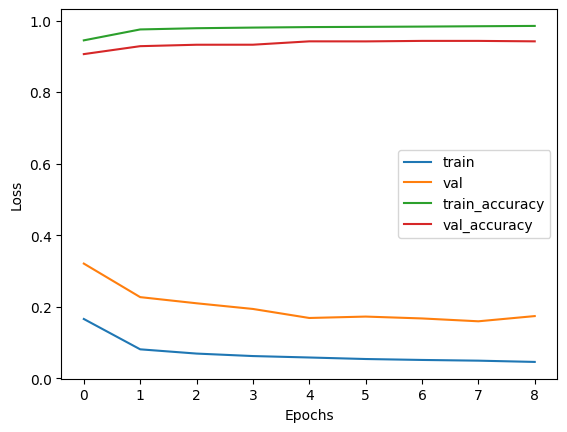

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
402/402 [==============================] - 1s 1ms/step
Classification Report:
              precision    recall  f1-score   support

         DoS       0.97      0.87      0.92      7458
       Probe       0.66      0.92      0.77      2421
         R2L       0.86      0.80      0.83      2887
         U2R       0.20      0.34      0.25        67

    accuracy                           0.86     12833
   macro avg       0.67      0.73      0.69     12833
weighted avg       0.88      0.86      0.87     12833

Confusion Matrix:
[[6459  652  347    0]
 [ 186 2234    1    0]
 [   2  480 2313   92]
 [   3   10   31   23]] 

MCC Score: 0.7732161640818853


In [103]:
# Article 4 Deep Neural Network for 4 class classification

# Import necessary libraries
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model, to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as pyplot

# Class to drop 'normal' or '4' for 4 class classification
class_to_drop = 4

# Create a mask to filter out the samples belonging to the specified class
mask_train = y_train != class_to_drop
mask_test = y_test != class_to_drop

# Filter the data based on the mask
y_train_filtered = y_train[mask_train]
X_train_filtered = X_train[mask_train]

y_test_filtered = y_test[mask_test]
X_test_filtered = X_test[mask_test]

# Number of classes 0 = DoS, 1 = Probe, 2 = R2L, 3 = U2R | lexicographic order | 4 class classification
n_classes = 4
y_train_encoded = to_categorical(y_train_filtered, num_classes=n_classes)
y_test_encoded = to_categorical(y_test_filtered, num_classes=n_classes)

# Number of features in the input data (40 total features)
n_inputs = 40

# Define the input layer
visible = Input(shape=(n_inputs,))

# Hidden Layer 1
e = Dense(80, activation='relu')(visible)  # 80 neurons with ReLU activation

# Hidden layer 2
e = Dense(40, activation='relu')(e) # 40 neurons with ReLU activation

# Hidden Layer 3
e = Dense(4, activation='relu')(e) # 4 neurons with ReLU activation

# Output Layer
output = Dense(4, activation='softmax')(e) # Condensed to 4 neurons (for 4 classes)

# Define the autoencoder model
model = Model(inputs=visible, outputs=output)

# Cast the input data to float32
X_train_filtered = X_train_filtered.astype('float32')
X_test_filtered = X_test_filtered.astype('float32')

# Compile the model with a suitable loss function for classification, e.g., categorical cross-entropy
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Possible Better performance when a fixed learning rate is NOT used with Adam Optimizer, however not as stable/consistent overall
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping with a patience of 6 steps
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Fit the autoencoder model to reconstruct input with batch size of 32 and 9 epochs
history = model.fit(X_train_filtered, y_train_encoded, epochs=9, batch_size=32, verbose=2, validation_split=0.15, callbacks=[early_stopping])

# Plot training loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.plot(history.history['accuracy'], label='train_accuracy')
pyplot.plot(history.history['val_accuracy'], label='val_accuracy')
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.legend()
pyplot.show()

# Define a deep network model
neural_network = Model(inputs=visible, outputs=output)
plot_model(neural_network, 'article4_multi_CTGAN.png', show_shapes=True)

# Save the neural_network model in Keras format
neural_network.save('article4_multi_CTGAN.keras')

#--------------------------------------------------------------------------------------------------------------------
# Data cleaning, preprocessing, sampling, and neural network has been applied prior to training
# SoftMax Regression Multiclass Classification (4 class)

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

# Make predictions on the test data
y_pred = neural_network.predict(X_test_filtered)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Print classification report and confusion matrix on the test set
class_names = ["DoS", "Probe", "R2L", "U2R"]
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes), "\n")

# Calculate MCC
mcc_score = matthews_corrcoef(y_test_classes, y_pred_classes)
print("MCC Score:", mcc_score)

##Run Softmax Regression & Test Performance

In [88]:
# Performance comparison classifiers as evaluated via 10-fold cross-validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from keras.models import load_model
from sklearn.linear_model import LogisticRegression

# Load the model from file
encoder = load_model('article4_multi_CTGAN.keras')

# Encode the training and testing data
X_train_encoded = encoder.predict(X_train_filtered)
X_test_encoded = encoder.predict(X_test_filtered)

# Create a softmax regression model
smr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Perform 10-fold cross-validation
y_pred = cross_val_predict(smr, X_train_encoded, y_train_filtered, cv=10, n_jobs=-1)

outputFile=open('Model Results CTGAN_02.txt','a')
confusion= confusion_matrix(y_train_filtered, y_pred)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
#Overall Accuracy
Accuracy_cla= accuracy_score(y_train_filtered, y_pred)
#Balanced Accuracy, Average of Recall/TPR and Efficiency/TNR
Bal_Accuracy_cla = 0.5*((TP/float(TP+FN))+(TN/float(TN+FP)))
#Precision
Pr_cla=precision_score(y_train_filtered, y_pred, average='weighted')
#Sensivity/Recall/TPR
Sn_cla= recall_score(y_train_filtered, y_pred, average='weighted')
#F1 Score
F1_cla = f1_score(y_train_filtered, y_pred, average='weighted')
#Specificity/Efficiency/TNR
Sp_cla =(TN/float(TN+FP))
#Compute MCC
MCC_cla = matthews_corrcoef(y_train_filtered, y_pred)

# Did not use AUC for multiclass
#Compute auROC/AUC
#AUC_cla = roc_auc_score(y_train, y_pred, multi_class='ovr')

# False Positive Rate
FPR_cla = (FP/float(TN+FP))
#False Negative Rate (Miss Rate)
FNR_cla = (FN/float(FN+TP))

Results='TFIDF Cross Validation Results: \n'
outputFile.write(str(Results))
outputFile.write('TP = %.0f\n'%TP)
outputFile.write('FP = %.0f\n'%FP)
outputFile.write('TN = %.0f\n'%TN)
outputFile.write('FN = %.0f\n'%FN)
print("\nConfusion Matrix")
print("{0}".format(confusion_matrix(y_train_filtered, y_pred)))
outputFile.write('Overall Accuracy = %.5f\n'%Accuracy_cla)
outputFile.write('Balanced Accuracy = %.5f\n'%Bal_Accuracy_cla)
outputFile.write('Precision = %.5f\n'%Pr_cla)
outputFile.write('Sensivity/Recall/TPR = %.5f\n'%Sn_cla)
outputFile.write('F1 Score = %.5f\n'%F1_cla)
outputFile.write('Specificity/Efficiency/TNR = %.5f\n'%Sp_cla)
outputFile.write('MCC = %.5f\n'%MCC_cla)
#outputFile.write('auROC = %.5f\n'%AUC_cla)
print("\nClassification Report")
print("{0}".format(classification_report(y_train_filtered, y_pred)))

outputFile.close()

402/402 [==============================] - 1s 2ms/step

Confusion Matrix
[[45888    36     3     0]
 [  984 38648   791     0]
 [   36  1359  1895     1]
 [    4   123   114     0]]

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     45927
           1       0.96      0.96      0.96     40423
           2       0.68      0.58      0.62      3291
           3       0.00      0.00      0.00       241

    accuracy                           0.96     89882
   macro avg       0.65      0.63      0.64     89882
weighted avg       0.96      0.96      0.96     89882



In [16]:
# Performance comparison classifiers as evaluated on independent test

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from keras.models import load_model
from sklearn.linear_model import LogisticRegression

# Load the model from file
encoder = load_model('article4_multi_CTGAN.keras')

# Encode the training and testing data
X_train_encoded = encoder.predict(X_train_filtered)
X_test_encoded = encoder.predict(X_test_filtered)

# Create a softmax regression model
smr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the model on the entire training set
smr.fit(X_train_encoded, y_train_filtered)

# Evaluate the model on the test set
y_pred = smr.predict(X_test_encoded)

outputFile=open('Model Results CTGAN_02.txt','a')
confusion= confusion_matrix(y_test_filtered, y_pred)
TP = confusion[1,1]
TN = confusion[0,0]
FP = confusion[0,1]
FN = confusion[1,0]
#Overall Accuracy
Accuracy_cla= accuracy_score(y_test_filtered, y_pred)
#Balanced Accuracy, Average of Recall/TPR and Efficiency/TNR
Bal_Accuracy_cla = 0.5*((TP/float(TP+FN))+(TN/float(TN+FP)))
#Precision
Pr_cla=precision_score(y_test_filtered, y_pred, average='weighted')
#Sensivity/Recall/TPR
Sn_cla= recall_score(y_test_filtered, y_pred, average='weighted')
#F1 Score
F1_cla = f1_score(y_test_filtered, y_pred, average='weighted')
#Specificity/Efficiency/TNR
Sp_cla =(TN/float(TN+FP))
#Compute MCC
MCC_cla = matthews_corrcoef(y_test_filtered, y_pred)

# Did not use AUC for multiclass
#Compute auROC/AUC
#AUC_cla = roc_auc_score(y_test, y_pred, multi_class='ovr')

# False Positive Rate
FPR_cla = (FP/float(TN+FP))
#False Negative Rate (Miss Rate)
FNR_cla = (FN/float(FN+TP))

Results='Independent Test Results:\n'
outputFile.write(str(Results))
outputFile.write('TP = %.0f\n'%TP)
outputFile.write('FP = %.0f\n'%FP)
outputFile.write('TN = %.0f\n'%TN)
outputFile.write('FN = %.0f\n'%FN)
print("\nConfusion Matrix")
print("{0}".format(confusion_matrix(y_test_filtered, y_pred)))
outputFile.write('Overall Accuracy = %.5f\n'%Accuracy_cla)
outputFile.write('Balanced Accuracy = %.5f\n'%Bal_Accuracy_cla)
outputFile.write('Precision = %.5f\n'%Pr_cla)
outputFile.write('Sensivity/Recall/TPR = %.5f\n'%Sn_cla)
outputFile.write('F1 Score = %.5f\n'%F1_cla)
outputFile.write('Specificity/Efficiency/TNR = %.5f\n'%Sp_cla)
outputFile.write('MCC = %.5f\n'%MCC_cla)
#outputFile.write('auROC = %.5f\n'%AUC_cla)
print("\nClassification Report")
print("{0}".format(classification_report(y_test_filtered, y_pred)))

outputFile.close()

402/402 [==============================] - 1s 1ms/step

Confusion Matrix
[[6472  369  617    0]
 [ 171 2155   95    0]
 [   6  229 2639   13]
 [   0    2   35   30]]

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      7458
           1       0.78      0.89      0.83      2421
           2       0.78      0.91      0.84      2887
           3       0.70      0.45      0.55        67

    accuracy                           0.88     12833
   macro avg       0.81      0.78      0.78     12833
weighted avg       0.89      0.88      0.88     12833



C:\Users\KUMR2195\AppData\Local\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


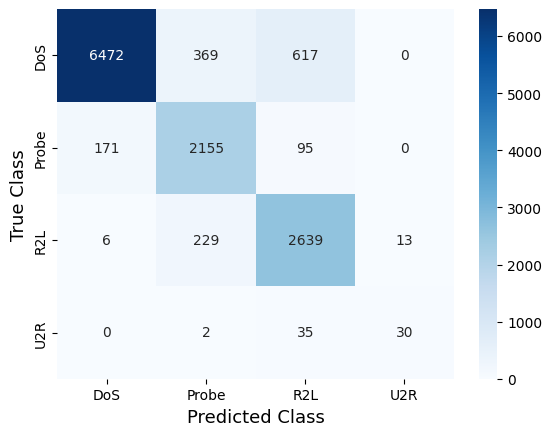

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion,
            cmap='Blues',
			annot=True,
			fmt='g',
			xticklabels=['DoS', 'Probe', 'R2L', 'U2R'],
			yticklabels=['DoS', 'Probe', 'R2L', 'U2R'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
#plt.title('Confusion Matrix for 4 Class', fontsize=17)
plt.savefig('Confusion Matrix for 4 Class',dpi=300);
plt.show()

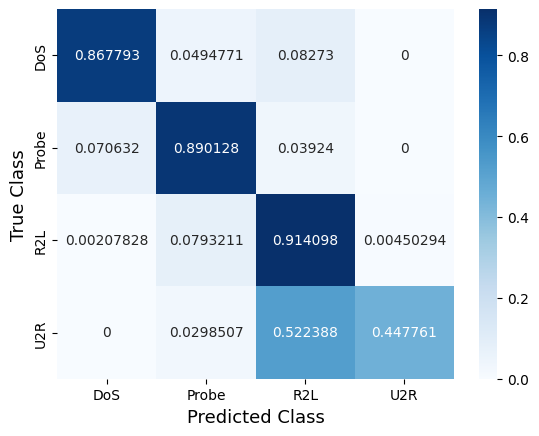

In [33]:
#Normalized confusion matrix
#Divide each row element by the sum of the entire row
cm_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_normalized,
            cmap='Blues',
			annot=True,
			fmt='g',
			xticklabels=['DoS', 'Probe', 'R2L', 'U2R'],
			yticklabels=['DoS', 'Probe', 'R2L', 'U2R'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
#plt.title('Confusion Matrix for 4 Class', fontsize=17)
plt.show()

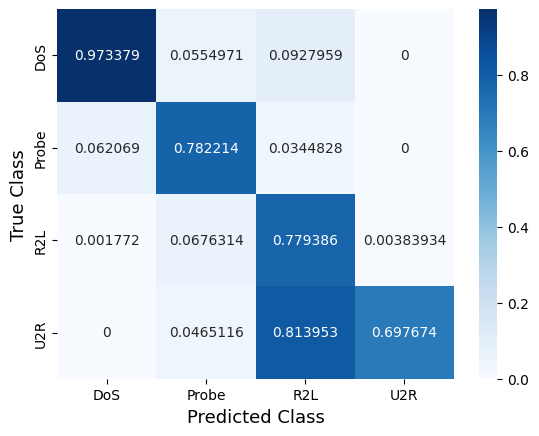

In [34]:
#Normalized confusion matrix
#Divide each column element by the sum of the entire column
cm_normalized = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]

sns.heatmap(cm_normalized,
            cmap='Blues',
			annot=True,
			fmt='g',
			xticklabels=['DoS', 'Probe', 'R2L', 'U2R'],
			yticklabels=['DoS', 'Probe', 'R2L', 'U2R'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
#plt.title('Confusion Matrix for 4 Class', fontsize=17)
plt.show()

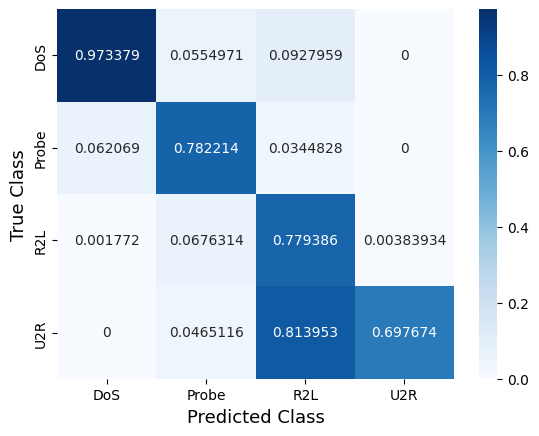

In [36]:
#Normalized confusion matrix
#Divide each element by the sum of the entire matrix
cm_normalized = confusion.astype('float') / sum(confusion)[:, np.newaxis]

sns.heatmap(cm_normalized,
            cmap='Blues',
			annot=True,
			fmt='g',
			xticklabels=['DoS', 'Probe', 'R2L', 'U2R'],
			yticklabels=['DoS', 'Probe', 'R2L', 'U2R'])
plt.ylabel('True Class', fontsize=13)
plt.xlabel('Predicted Class', fontsize=13)
#plt.title('Confusion Matrix for 4 Class', fontsize=17)
plt.show()

0.9275280984365158
0.9422519578734098
0.9691060162703328
0.9149372984677117
AUC for Class 0: 0.93
AUC for Class 1: 0.94
AUC for Class 2: 0.97
AUC for Class 3: 0.91


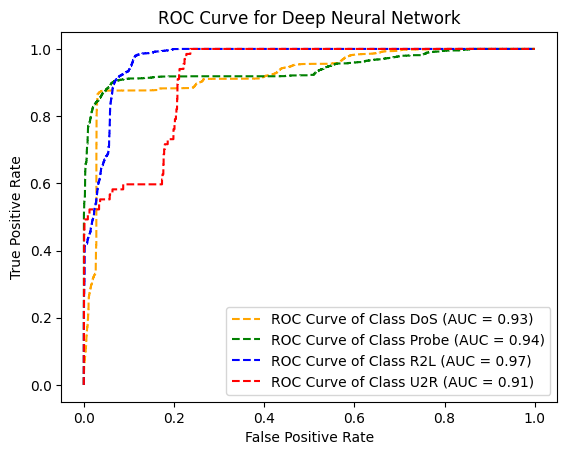

In [17]:
pred_prob = smr.predict_proba(X_test_encoded)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
auc_score = {}
 
n_class = 4

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_filtered, pred_prob[:,i], pos_label=i)
    auc_score[i] = auc(fpr[i], tpr[i])


print(auc_score[0])
print(auc_score[1])
print(auc_score[2])
print(auc_score[3])

# Print and round AUC scores to 2 decimal places
for i in range(n_class):
    auc_score[i] = round(auc_score[i], 2)
    print("AUC for Class {}: {}".format(i, auc_score[i]))

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='ROC Curve of Class DoS (AUC = {})'.format(auc_score[0]))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='ROC Curve of Class Probe (AUC = {})'.format(auc_score[1]))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='ROC Curve of Class R2L (AUC = {})'.format(auc_score[2]))
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='ROC Curve of Class U2R (AUC = {})'.format(auc_score[3]))

plt.title('ROC Curve for Deep Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.savefig('ROC Curve for Deep Neural Network',dpi=300);

In [80]:
synth_data0 = pd.read_csv('synth_data0.csv')
synth_data3 = pd.read_csv('synth_data3.csv')
synth_data0.equals(synth_data3)

True

## XGB Classifier

In [90]:
#https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn
from xgboost import XGBClassifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

# Create XGB classifer object
params = {
    "colsample_bytree": 0.76,
    "gamma": 0.42,
    "learning_rate": 0.71, # default 0.1 
    "max_depth": 3, # default 3
    "n_estimators": 120, # default 100
    "subsample": 0.82
}
XGB_clf = XGBClassifier(params)

# Train XGB Classifer
XGB_clf = XGB_clf.fit(X_train_encoded, y_train_filtered)

# Make prediction on the testing data
y_pred = XGB_clf.predict(X_test_encoded)

# Classification Report
print(classification_report(y_test_filtered, y_pred))

C:\Users\KUMR2195\AppData\Local\anaconda3\envs\ml\lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7458
           1       0.46      0.94      0.62      2421
           2       0.98      0.50      0.66      2887
           3       0.69      0.36      0.47        67

    accuracy                           0.78     12833
   macro avg       0.78      0.66      0.66     12833
weighted avg       0.88      0.78      0.79     12833

